#### 공사비 1차 전처리

* 계약전력: 100미만
* 접수종류명: 신설(상용/임시)
* 컬럼값이 1개로 구성된 컬럼(학습에 영향이 없음)
* 총공사비가 1억 이상인 레코드 제거(11개 레코드)
* 공사형태명: '외선소요'만 처리(나머지 '외선소요(선공급)' , '외선불요'는 갯 수가 140개도 안됨)

In [1]:
import re
import pandas as pd
from datetime import datetime

from aiddd.data_manager import read_data, write_data

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings

plt_settings()

#### 원본 데이터 불러오기

In [2]:
_start = datetime.now()
df_data = read_data('2nd CONS')
print(
    f'Total Elapsed Time for Data Load: {datetime.now()-_start}\n'
    f'Shape: {df_data.shape}'
)

Total Elapsed Time for Data Load: 0:00:18.623921
Shape: (19052, 143)


#### 데이터 전처리

##### 결측치 처리

In [3]:
df_data.isna().sum().sort_values(ascending=False)[:5]
# '신기술공종규격코드', '전선변압기코드번호', '상태코드' 3컬럼이 모두 결측치이기 때문에,
# 단일값인 0으로 치환 후 이후 단일값으로 구성된 컬럼 삭제시 제거

신기술공종규격코드    19052
전선변압기코드번호    19052
CUD상태코드      19052
공사번호             0
더블블레이드수익금        0
dtype: int64

In [4]:
df_data.fillna(0, inplace=True)

##### 제외대상 제거
* 계약전력: 100미만
* 접수종류명: '신설(상용/임시)'
* 공사형태코드: 2(외선소요)

In [5]:
condition = (df_data['접수종류명']=='신설(상용/임시)') & \
            (df_data['계약전력'] < 100) & (df_data['공사형태코드'] == 2)
df_data[~condition].shape
# 전체 레코드(19,052)중에 3,112이 제거 대상

(3112, 143)

In [6]:
# 조건에 맞는 레크드만 취하고 인덱스를 갱신함
df_data = df_data[condition].reset_index(drop=True)

##### 1개의 값으로 구성된 컬럼 제거

In [7]:
# 컬럼별로 유일한 값의 갯 수 확인
unique_cnt_cols = df_data.nunique()

# 유일값이 1과 같거나 적은 컬럼명 추출
# 위에서 모두 NaN이였던 컬럼 3개도 NaN값을 0으로 치환해 유일값이 1개로 같이 제거됨
single_value_cols = unique_cnt_cols[unique_cnt_cols <= 1].index

# 데이터프레임에서 해당 컬럼 제거
df_data.drop(columns=single_value_cols, axis=1, inplace=True)

# 결과확인
print(
    f'Number of Drop Columns: {len(single_value_cols)}\n'
    f'Columns: {[col for col in single_value_cols]}\n'
    f'Data shape: {df_data.shape}'
)

Number of Drop Columns: 89
Columns: ['공사변경순번', '배전공사형태코드', '외자분재료비', '사업소재료비금액', '간접재료비', '작업부산물값', '전선변압기코드번호', '전선변압기추가금액', '전선변압기조정금액', '인력분기준비용', '기계분기준비용', '할선분기준비용', '전선기술노무비', '전선기술재료비', '전선기술경비', '무정전기술노무비', '무정전기술경비', '도급분무정전기술노무비', '도급분무정전기술경비', '감리총공사비', '폐기물총공사비', '자동화총공사비', '도통시험총공사비', '전주가지지공법노무비', '전주가지지공법경비', '공통공사비', '가설공사비1', '가설공사비2', '공동장비비용', '현장관리비', '직접공사비', '회사분직접공사비', '도급분직접공사비', '간접공사비', '가공분단위시설별공사비', '지중분단위시설별공사비', '가공분회사분재료비', '지중분회사분재료비', '가공분도급분재료비', '지중분도급분재료비', '감리자본적금액', '감리수익적금액', '폐기자본적금액', '폐기수익적금액', '도통자본적금액', '도통수익적금액', '자동화자본적금액', '자동화수익적금액', '자본대비자본적비율', '수익대비수익적비율', '원형전주버팀목공법자재비', '원형전주버팀목공법노무비', '원형전주버팀목공법경비', '도급분원형전주버팀목공법자재비', '도급분원형전주버팀목공법노무비', '도급분원형전주버팀목공법경비', '더블블레이드총공사비', '더블블레이드자본금액', '더블블레이드수익금', '사급자재자체감리비', '고객부담자체감리비', '부대공사자체감리비', '신기술공종규격코드', '신기술공사비', '신기술적용대수', '신기술적용선로길이', '중공스크루로드총공사비', '중공스크루로드자본적금액', '중공스크루로드수익적금액', 'CUD상태코드', '손실보상금', '손실보상계수', '무정전전선이선공사비', '무정전전선이선특허사용료율', '방호대총공사비', '방호대자본적금액', '방호대수익적금액', '미관개선총공사비', 

#### 개별 컬럼 특징확인

In [8]:
df_data.columns

Index(['공사번호', '회사분공사비', '도급분공사비', '자본적금액', '수익적금액', '본사분재료비', '내자분재료비',
       '내자분저장품재료비', '내자분비저장품재료비', '도급분재료비', '지입재료비', '잡재료비', '직접노무비', '간접노무비',
       '기계경비', '공구손료', '회사분경비', '도급분경비', '무정전기준비용', '신설기준비용', '철거기준비용',
       '일반관리비', '이윤', '총공사비', '재료비', '회사분재료비', '노무비', '경비', '운반비', '자본적비율',
       '수익적비율', '도급분자본적금액', '도급분수익적금액', '도급분자본적비율', '도급분수익적비율', '전주파쇄비',
       '기타자재파쇄비', '아치형전주버팀목공법자재비', '아치형전주버팀목공법노무비', '아치형전주버팀목공법경비',
       '고객부담일반관리비', '복리후생비율', '소모품비율', '여비통신비율', '세금공과금비율', '아치형전주버팀목공법일반관리비',
       '아치형전주버팀목공법이윤', '아치형전주버팀목공법기술료율', '최초등록일시', '최초등록자사번', '최종변경일시',
       '최종변경자사번', '사업소명', '계약전력'],
      dtype='object')

##### 공사번호 영문포함 여부

In [9]:
# 공사번호에 영문 포함 여부 확인
df_data['공사번호'][df_data['공사번호'].str.contains('[a-zA-Z]')].shape

# 2203개가 영문이 포함된 공사비임

(2189,)

##### 총공사비 이상치(또는 특별값) 제거

In [10]:
# 총공사비 최소/최대값 확인
df_data['총공사비'].min(), df_data['총공사비'].max()

(739093, 418398497)

In [11]:
condition_cost = (df_data['총공사비'] > 99999999)
df_data[condition_cost].shape

# 총공사비가 1억 이상인 대상이 11개뿐이니 제거하고 처리

(11, 54)

In [12]:
df_data = df_data[~condition_cost].reset_index(drop=True)

##### 날짜데이터 확인

In [13]:
df_data[['최초등록일시', '최종변경일시']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15929 entries, 0 to 15928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   최초등록일시  15929 non-null  datetime64[ns]
 1   최종변경일시  15929 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 249.0 KB


In [14]:
df_data[['최초등록일시', '최종변경일시']].head()

,최초등록일시,최종변경일시
0,2021-06-03 08:21:39,2021-06-03 08:21:40
1,2021-06-16 16:59:17,2021-06-16 16:59:17
2,2021-02-25 09:10:17,2021-02-25 09:10:18
3,2021-02-25 13:52:47,2021-02-25 13:52:47
4,2021-04-12 08:11:23,2021-04-12 08:11:24


In [15]:
# 최종변경일시와 최초등록일시가 1시간 이상(3600초) 차이나는 레코드 확인
condition_date = (
    (df_data['최종변경일시'] - df_data['최초등록일시']).dt.total_seconds() >= 3600
)
df_data[condition_date].shape

# 최초등록일시와 최종변경일시가 1시간 차이도 안나기 때문에 '최종변경일시'만 사용

(0, 54)

In [16]:
df_data['year'] = df_data['최종변경일시'].dt.year
df_data['month'] = df_data['최종변경일시'].dt.month
df_data['day'] = df_data['최종변경일시'].dt.day
df_data['dayofweek'] = df_data['최종변경일시'].dt.dayofweek
df_data['dayofyear'] = df_data['최종변경일시'].dt.dayofyear

##### 사번확인

In [17]:
df_data[['최초등록자사번', '최종변경자사번']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15929 entries, 0 to 15928
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   최초등록자사번  15929 non-null  object
 1   최종변경자사번  15929 non-null  object
dtypes: object(2)
memory usage: 249.0+ KB


In [18]:
df_data[['최초등록자사번', '최종변경자사번']].head()

,최초등록자사번,최종변경자사번
0,MDP2100104,MDP2100104
1,MDE1706013,MDE1706013
2,1988103181,1988103181
3,MDE1706013,MDE1706013
4,MDP2100086,MDP2100086


In [19]:
condition_id = (df_data['최초등록자사번'] != df_data['최종변경자사번'])
df_data[condition_id].shape

# 등록자와 변경자의 사번이 모두 일치하기 때문에 최종변경자사번만 사용

(0, 59)

In [20]:
# 최종변경자사번에서 알파벳 추출
df_data['사번코드'] = df_data['최종변경자사번'].str.extract('([a-zA-Z]+)', expand=False)
df_data['사번코드'].value_counts()

사번코드
MDP    6197
MDE    5573
MDF    1084
MDO     853
MDA     667
MDJ     120
MMP      11
MDI       1
Name: count, dtype: int64

In [21]:
df_data['사번코드'].value_counts().sum(), df_data.shape
# 전체데이터 16073중 영문에 포함된 사번은 14637이며 종류는 8개임

(14506, (15929, 60))

##### 사번코드를 숫자로 만들기

In [22]:
# 사번코드를 숫자로 만들기
df_data['사번코드'].fillna('AAA', inplace=True)
df_data['사번코드숫자'] = df_data['사번코드'].rank(method='dense').astype(int)

In [23]:
# 사번코드가 숫자로 잘 만들어 졌는지 확인하기 위해,
# 사번코드별로 하나의 레코드를 추출해 사번과 사번코드 및 사번코드숫자를 확인
unique_id_code = sorted(df_data['사번코드'].unique())
unique_id_index = []
for id_code in unique_id_code:
    unique_id_index.append(df_data[df_data['사번코드']==id_code].index[0])

print([code for code in unique_id_code])
print([idx for idx in unique_id_index])
    
df_unique_id_code = df_data.iloc[unique_id_index]
df_unique_id_code[['최종변경자사번', '사번코드', '사번코드숫자']]

['AAA', 'MDA', 'MDE', 'MDF', 'MDI', 'MDJ', 'MDO', 'MDP', 'MMP']
[2, 2696, 1, 4035, 4034, 8127, 1014, 0, 8237]


,최종변경자사번,사번코드,사번코드숫자
2,1988103181,AAA,1
2696,MDA1570558,MDA,2
1,MDE1706013,MDE,3
4035,MDF1710844,MDF,4
4034,MDI1781912,MDI,5
8127,MDJ1563132,MDJ,6
1014,MDO2100010,MDO,7
0,MDP2100104,MDP,8
8237,MMP1900092,MMP,9


In [24]:
df_data['사번숫자'] = df_data['최종변경자사번'].apply(lambda x: re.findall(r'\d+', x))


In [25]:
def change_data(x):
    return int(x[0])

df_data['사번숫자'] = df_data['사번숫자'].apply(change_data)

##### 사업소명 확인

In [26]:
df_data['사업소명'].value_counts()

사업소명
증평괴산지사    2189
동청주지사     1852
충주지사      1737
영동지사      1552
제천지사      1487
음성지사      1353
보은지사      1343
충북본부직할    1327
옥천지사      1185
진천지사      1065
단양지사       839
Name: count, dtype: int64

In [27]:
# 사업소명을 숫자로 변경
df_data['사업소코드'] = df_data['사업소명'].rank(method='dense').astype(int)

In [28]:
df_data['사업소코드'].value_counts()

사업소코드
8     2189
2     1852
11    1737
4     1552
7     1487
6     1353
3     1343
10    1327
5     1185
9     1065
1      839
Name: count, dtype: int64

#### 학습에 사용할 컬럼

In [29]:
feature_cols = [
    '공사번호', '총공사비', 
    '최종변경일시', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
    '최종변경자사번', '사번코드', '사번코드숫자', '사번숫자',
    '사업소명', '사업소코드', '계약전력'
]

In [30]:
df_data = df_data[feature_cols]

#### 데이터 저장

In [31]:
write_data('2nd pp cons1', df_data, index=False)

#### 차트로 확인

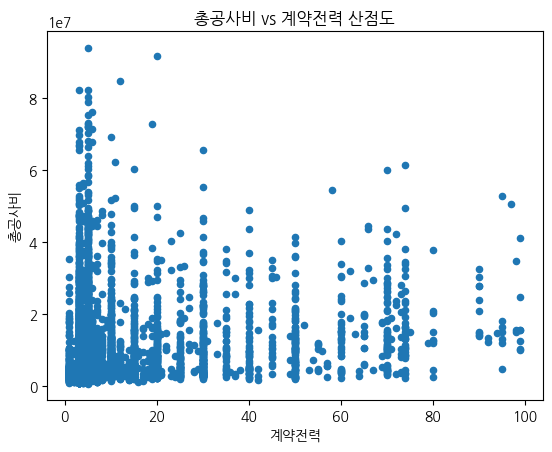

In [32]:
df_data.plot.scatter(x='계약전력', y='총공사비')
plt.xlabel('계약전력')
plt.ylabel('총공사비')
plt.title('총공사비 vs 계약전력 산점도')
plt.show()

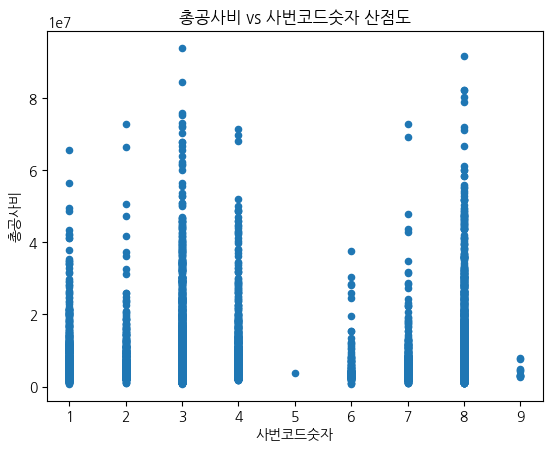

In [33]:
df_data.plot.scatter(x='사번코드숫자', y='총공사비')
plt.xlabel('사번코드숫자')
plt.ylabel('총공사비')
plt.title('총공사비 vs 사번코드숫자 산점도')
plt.show()